In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode
from pyspark.sql.types import StructType, ArrayType
from pyspark.sql import functions as F
from helper import (
    read_sql_file, 
    plot_multiple_line_graphs, 
    plot_multiple_line_graphs2,
    thousands_formatter,
    millions_formatter,
    billions_formatter,
    trillions_formatter,
)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Big Data And Cloud Computing Laboratory Report

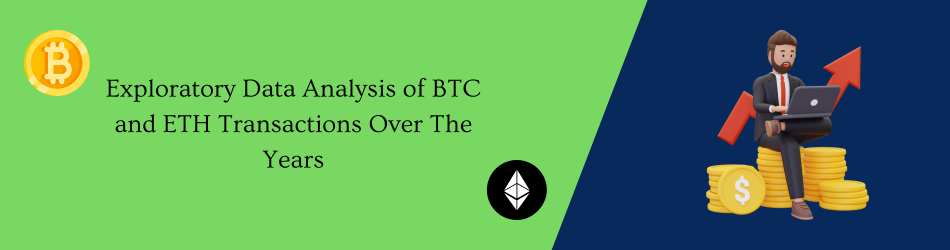

## EXECUTIVE SUMMARY

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## INTRODUCTION

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Create Spark Session 

In [2]:
spark = SparkSession.builder.appName("BDCCLab").master("local[*]").getOrCreate()

In [3]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

## Show Raw Data Size 

In [4]:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/

901G	/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/


In [5]:
# Size of data being processed:
!du -sh /mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/

1.5T	/mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/


## Read Raw Data

In [6]:
df_eth_trans = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/eth/transactions/")

In [23]:
df_eth_blocks = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/eth/blocks/")

In [7]:
df_btc_trans = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/btc/transactions/")

In [8]:
df_btc_blocks = spark.read.option("mergeSchema", "true").parquet("/mnt/data/public/aws-public-blockchain/v1.0/btc/blocks/")

## ETH Transactions Schema

In [9]:
df_eth_trans.printSchema()

root
 |-- gas: long (nullable = true)
 |-- hash: string (nullable = true)
 |-- input: string (nullable = true)
 |-- nonce: long (nullable = true)
 |-- value: double (nullable = true)
 |-- block_number: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- transaction_index: long (nullable = true)
 |-- from_address: string (nullable = true)
 |-- to_address: string (nullable = true)
 |-- gas_price: long (nullable = true)
 |-- receipt_cumulative_gas_used: long (nullable = true)
 |-- receipt_gas_used: long (nullable = true)
 |-- receipt_contract_address: string (nullable = true)
 |-- receipt_status: long (nullable = true)
 |-- receipt_effective_gas_price: long (nullable = true)
 |-- transaction_type: long (nullable = true)
 |-- max_fee_per_gas: long (nullable = true)
 |-- max_priority_fee_per_gas: long (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- last_modified: timestamp (nullable = true)



Data Dictionary for ETH transactions <sup>1</sup>

Field | Type | Description 
--- | --- | ---
date | string | Partition column (YYYY-MM-DD)
hash | string | Hash of the transaction
nonce | bigint | The number of transactions made by the sender prior to this one
transaction_index | bigint | Integer of the transactions index position in the block
from_address | string | Address of the sender
to_address | string | Address of the receiver
value | double | Value transferred in wei      
gas | bigint | Gas price provided by the sender in wei       
gas_price | bigint | Gas provided by the sender
input | string | The data sent along with the transaction
receipt_cumulative_gas_used | bigint | The total amount of gas used when this transaction was executed in the block
receipt_gas_used | bigint | The amount of gas used by this specific transaction alone
receipt_contract_address | string | The contract address created, if the transaction was a contract creation
receipt_status | bigint | If the transaction was successful
block_timestamp | timestamp | The unix timestamp for when the block was collated
block_number | bigint | Block number where this transaction was in
block_hash | string | Hash of the block
max_fee_per_gas | bigint | Total fee that covers both base and priority fees
max_priority_fee_per_gas | bigint | Fee given to miners to incentivize them to include the transaction
transaction_type | bigint | Transaction type
receipt_effective_gas_price | bigint | The actual value per gas deducted from the senders account.

## ETH Blocks Schema

In [24]:
df_eth_blocks.printSchema()

root
 |-- difficulty: double (nullable = true)
 |-- hash: string (nullable = true)
 |-- miner: string (nullable = true)
 |-- nonce: string (nullable = true)
 |-- number: long (nullable = true)
 |-- size: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- total_difficulty: double (nullable = true)
 |-- base_fee_per_gas: long (nullable = true)
 |-- gas_limit: long (nullable = true)
 |-- gas_used: long (nullable = true)
 |-- extra_data: string (nullable = true)
 |-- logs_bloom: string (nullable = true)
 |-- parent_hash: string (nullable = true)
 |-- state_root: string (nullable = true)
 |-- receipts_root: string (nullable = true)
 |-- transactions_root: string (nullable = true)
 |-- sha3_uncles: string (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- date: date (nullable = true)
 |-- last_modified: timestamp (nullable = true)



Data Dictionary for ETH blocks <sup>2</sup>

Field | Type | Description 
--- | --- | ---
date | string | Partition column (YYYY-MM-DD)
timestamp | timestamp | The unix timestamp for when the block was collated
number | bigint | The block number
hash | string | Hash of the block
parent_hash | string | Hash of the parent block
nonce | string | Hash of the generated proof-of-work
sha3_uncles | string | SHA3 of the uncles data in the block
logs_bloom | string | The bloom filter for the logs of the block
transactions_root | string | The root of the transaction trie of the block
state_root | string | The root of the final state trie of the block
receipts_root | string | The root of the receipts trie of the block
miner | string | The address of the beneficiary to whom the mining rewards were given
difficulty | double | Difficulty for this block
total_difficulty | double | Total difficulty of the chain until this block
size | bigint | The size of this block in bytes
extra_data | string | The “extra data” field of this block
gas_limit | bigint | The maximum gas allowed in this block
gas_used | bigint | The total used gas by all transactions in this block
transaction_count | bigint | Number of transactions in this block
base_fee_per_gas | bigint | Minimum to be charged to send a transaction on the network

## BTC Transactions Schema

In [10]:
df_btc_trans.printSchema()

root
 |-- hash: string (nullable = true)
 |-- version: long (nullable = true)
 |-- size: long (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- block_number: long (nullable = true)
 |-- virtual_size: long (nullable = true)
 |-- lock_time: long (nullable = true)
 |-- input_count: long (nullable = true)
 |-- output_count: long (nullable = true)
 |-- is_coinbase: boolean (nullable = true)
 |-- output_value: double (nullable = true)
 |-- outputs: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- required_signatures: long (nullable = true)
 |    |    |-- script_asm: string (nullable = true)
 |    |    |-- script_hex: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- value: double (nullable = true)
 |    |    |-- address: string (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- index: long (nullable = tru

Data Dictionary for BTC transactions <sup>2</sup>

Field | Nested Field | Type | Description 
--- | --- | --- | ---
date | | string | Partition column (YYYY-MM-DD)
hash | | string | The hash of this transaction
size | | bigint | The size of this transaction in bytes
virtual_size | | bigint | The virtual transaction size (differs from size for witness transactions)
version | | bigint | Protocol version specified in block which contained this transaction
lock_time | | bigint | Earliest time that miners can include the transaction in their hashing of the Merkle root to attach it in the latest block of the blockchain
block_hash | | string | Hash of the block which contains this transaction
block_number | | bigint | Number of the block which contains this transaction
block_timestamp | | timestamp | Timestamp of the block which contains this transaction
index | | bigint | The index of the transaction in the block
input_count | | bigint | The number of inputs in the transaction
output_count | | bigint | The number of outputs in the transaction
input_value | | double | Total value of inputs in the transaction (in BTC)
output_value | | double | Total value of outputs in the transaction (in BTC)
is_coinbase | | boolean | True if this transaction is a coinbase transaction
fee | | double | The fee paid by this transaction
inputs | | array | Transaction inputs
inputs | index | bigint | 0 indexed number of an input within a transaction
inputs | spent_transaction_hash | string | The hash of the transaction which contains the output that this input spends
inputs | spent_output_index | bigint | The index of the output this input spends
inputs | script_asm | string | Symbolic representation of the bitcoins script language op-codes
inputs | script_hex | string | Hexadecimal representation of the bitcoins script language op-codes
inputs | sequence | bigint | A number intended to allow unconfirmed time-locked transactions to be updated before being finalized; not currently used except to disable locktime in a transaction
inputs | required_signatures | bigint | The number of signatures required to authorize the spent output
inputs | type | string | The address type of the spent output
inputs | address | string | Address which owns the spent output
inputs | value | double | The value in BTC attached to the spent output
outputs | | array | Transaction outputs
outputs | index | bigint | 0 indexed number of an output within a transaction used by a later transaction to refer to that specific output
outputs | script_asm | string | Symbolic representation of the bitcoins script language op-codes
outputs | script_hex | string | Hexadecimal representation of the bitcoins script language op-codes
outputs | required_signatures | bigint | The number of signatures required to authorize spending of this output
outputs | type | string | The address type of the output
outputs | address | string | Address which owns this output
outputs | value | double | The value in BTC attached to this output

## BTC Blocks Schema

In [11]:
df_btc_blocks.printSchema()

root
 |-- hash: string (nullable = true)
 |-- version: long (nullable = true)
 |-- mediantime: timestamp (nullable = true)
 |-- nonce: long (nullable = true)
 |-- bits: string (nullable = true)
 |-- difficulty: double (nullable = true)
 |-- chainwork: string (nullable = true)
 |-- size: long (nullable = true)
 |-- weight: long (nullable = true)
 |-- coinbase_param: string (nullable = true)
 |-- number: long (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- merkle_root: string (nullable = true)
 |-- stripped_size: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- previousblockhash: string (nullable = true)
 |-- last_modified: timestamp (nullable = true)



Data Dictionary for BTC blocks <sup>2</sup>

| Field             | Type      | Description                                                |
|-------------------|-----------|------------------------------------------------------------|
| date              | string    | Partition column (YYYY-MM-DD)                              |
| hash              | string    | Hash of this block                                         |
| size              | bigint    | The size of block data in bytes                            |
| stripped_size     | bigint    | The size of block data in bytes excluding witness data     |
| weight            | bigint    | Three times the base size plus the total size              |
| number            | bigint    | The number of the block                                    |
| version           | int       | Protocol version specified in block header                 |
| merkle_root       | string    | The root node of a Merkle tree, where leaves are transaction hashes |
| timestamp         | timestamp | Block creation timestamp specified in block header         |
| nonce             | bigint    | Difficulty solution specified in block header              |
| bits              | string    | Difficulty threshold specified in block header             |
| coinbase_param    | string    | Data specified in the coinbase transaction of this block   |
| transaction_count | bigint    | Number of transactions included in this block              |
| mediantime        | timestamp |                                                            |
| difficulty        | double    |                                                            |
| chainwork         | string    |                                                            |
| previousblockhash | string    |                                                            |

## Register Temporary Views

In [27]:
df_eth_trans.createOrReplaceTempView("df_eth_trans")
df_eth_blocks.createOrReplaceTempView("df_eth_blocks")
df_btc_trans.createOrReplaceTempView("df_btc_trans")
df_btc_blocks.createOrReplaceTempView("df_btc_blocks")

## BTC and ETH Comparisons on Count and Total and Average Value and Fees

In [13]:
eth_tot_trans = spark.sql(read_sql_file("sql/eth_tot_trans.sql")).toPandas()
eth_tot_trans

,year,total_value,total_gas,avg_value,avg_gas,total_transactions
0,2015,9.184474e+07,0.066232,87.781841,6.330245e-08,1046284
1,2016,6.625570e+08,0.409877,48.499609,3.000327e-08,13661080
2,2017,4.353256e+09,2.557807,42.288832,2.484730e-08,102941034
3,2018,1.142012e+09,5.449470,4.546831,2.169664e-08,251166529
4,2019,7.653053e+08,3.824180,3.151582,1.574825e-08,242832115
5,2020,9.428725e+08,23.000077,2.734811,6.671195e-08,344766970
6,2021,9.920981e+08,47.371433,2.148294,1.025783e-07,461807363
7,2022,6.946280e+08,19.230624,1.700256,4.707121e-08,408543268
8,2023,4.534225e+08,12.622046,1.183560,3.294708e-08,383100651
9,2024,1.851720e+08,4.934517,1.192735,3.178433e-08,155249958


In [14]:
btc_tot_trans = spark.sql(read_sql_file("sql/btc_tot_trans.sql")).toPandas()
btc_tot_trans

,year,avg_value,avg_fee,total_value,total_fee,total_transactions
0,2009,230.000000,0.000000,1.150000e+03,0.000000,32709
1,2010,134.682635,0.000229,1.271040e+07,21.591013,185305
2,2011,160.148884,0.001676,2.948767e+08,3086.340796,1901765
3,2012,109.886395,0.000811,9.168147e+08,6766.706688,8453050
4,2013,21.875829,0.000780,4.283245e+08,15274.635981,19643241
5,2014,10.422027,0.000184,2.626857e+08,4636.574089,25263720
6,2015,11.955067,0.000180,5.391198e+08,8109.502888,45674023
7,2016,12.927879,0.000273,1.067038e+09,22548.383140,82626623
8,2017,8.960290,0.000965,9.319356e+08,100370.686083,104063229
9,2018,5.174042,0.000315,4.196391e+08,25544.523016,81395636


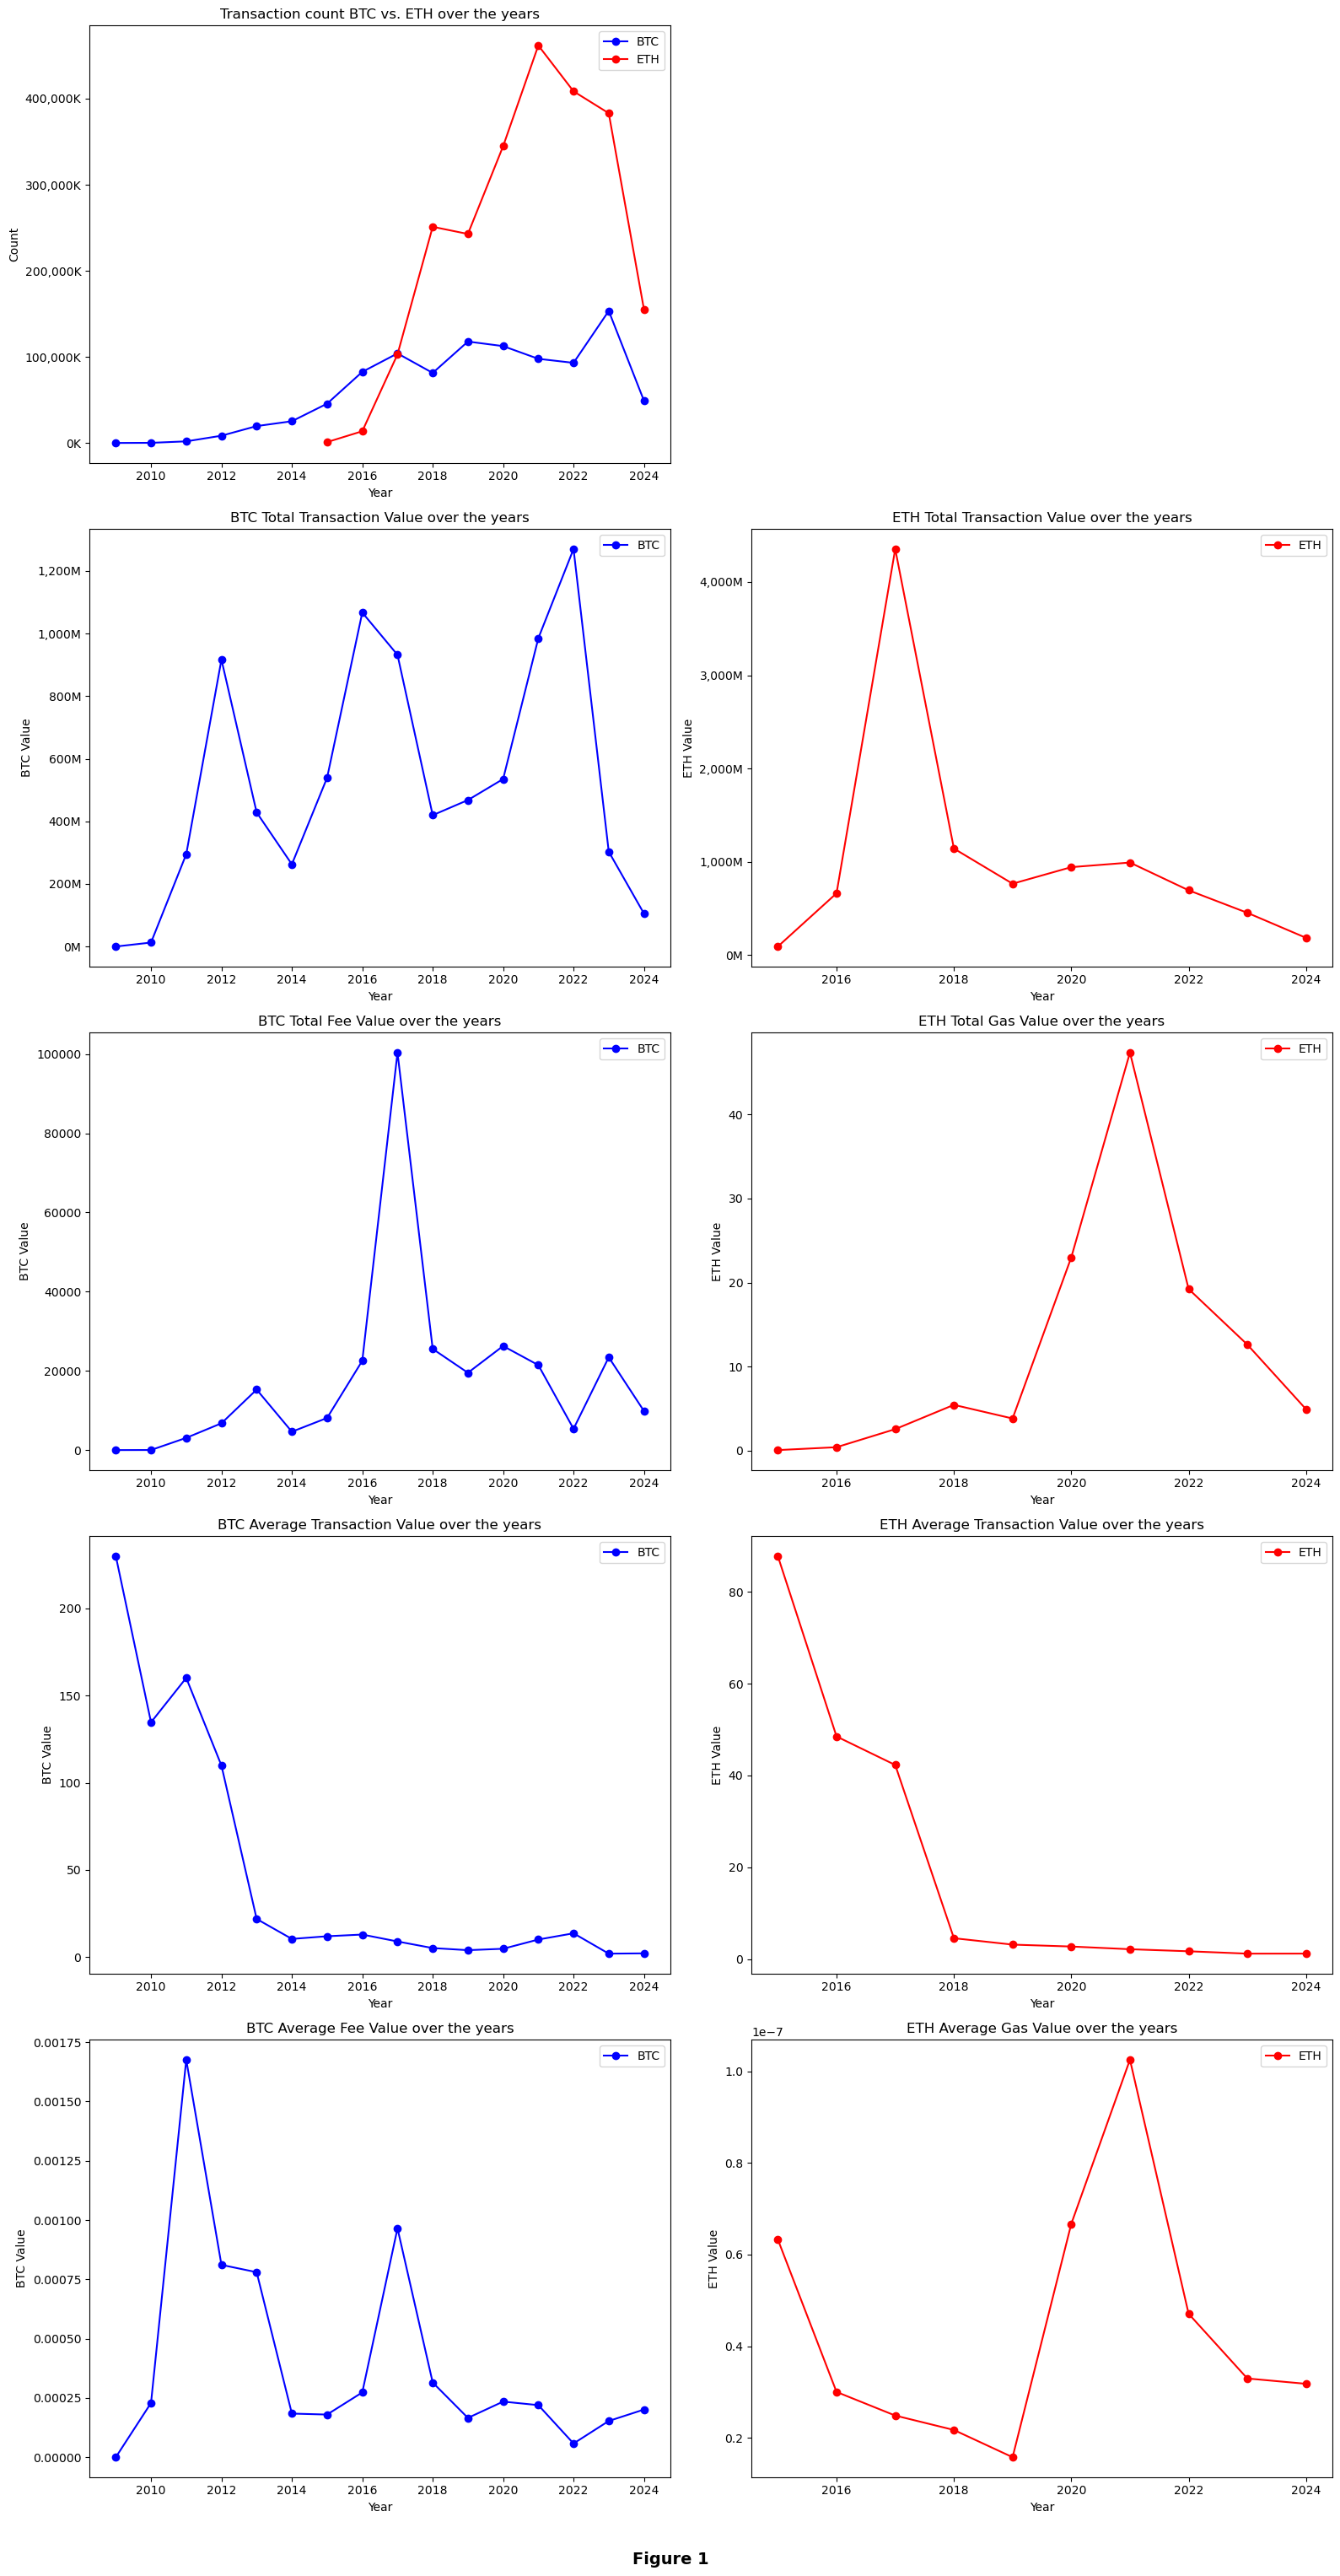

In [110]:
plot_multiple_line_graphs2(
    x_list=[[btc_tot_trans["year"], eth_tot_trans["year"]], None,] + [btc_tot_trans["year"], eth_tot_trans["year"]] * 4,
    y_list=[
        [
            (btc_tot_trans["total_transactions"], "BTC", "b"),
            (eth_tot_trans["total_transactions"], "ETH", "r"),
        ],
        [],
        (btc_tot_trans["total_value"], "BTC", "b"), 
        (eth_tot_trans["total_value"], "ETH", "r"),
        (btc_tot_trans["total_fee"], "BTC", "b"), 
        (eth_tot_trans["total_gas"], "ETH", "r"),
        (btc_tot_trans["avg_value"], "BTC", "b"),
        (eth_tot_trans["avg_value"], "ETH", "r"),
        (btc_tot_trans["avg_fee"], "BTC", "b"), 
        (eth_tot_trans["avg_gas"], "ETH", "r"),
    ],
    x_labels=["Year",] * 10,
    y_labels=["Count", "",] + ["BTC Value", "ETH Value"]*4,
    titles=[
        "Transaction count BTC vs. ETH over the years", 
        "", 
        "BTC Total Transaction Value over the years", 
        "ETH Total Transaction Value over the years", 
        "BTC Total Fee Value over the years", 
        "ETH Total Gas Value over the years", 
        "BTC Average Transaction Value over the years", 
        "ETH Average Transaction Value over the years", 
        "BTC Average Fee Value over the years", 
        "ETH Average Gas Value over the years", 
    ],
    # use_k=[True] + [False] * 9,
    formatter=[thousands_formatter, None] + [millions_formatter]*2 + [None]*2 + [None]*2 + [None]*2,
    use_legend=[True] * 10,
    show_grid=False,
    max_cols=2,
    start_figure_number=1
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## ETH and BTC Transactions Per Second

In [16]:
tps_trans = spark.sql(read_sql_file("sql/tps_trans.sql")).toPandas().fillna(0)
tps_trans

,year,eth_transactions_per_sec,btc_transactions_per_sec
0,2009,0.000000,0.001057
1,2010,0.000000,0.005876
2,2011,0.000000,0.060305
3,2012,0.000000,0.267312
4,2013,0.000000,0.622883
5,2014,0.000000,0.801107
6,2015,0.082379,1.448314
7,2016,0.432006,2.612914
8,2017,3.264239,3.299823
9,2018,7.964438,2.581039


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

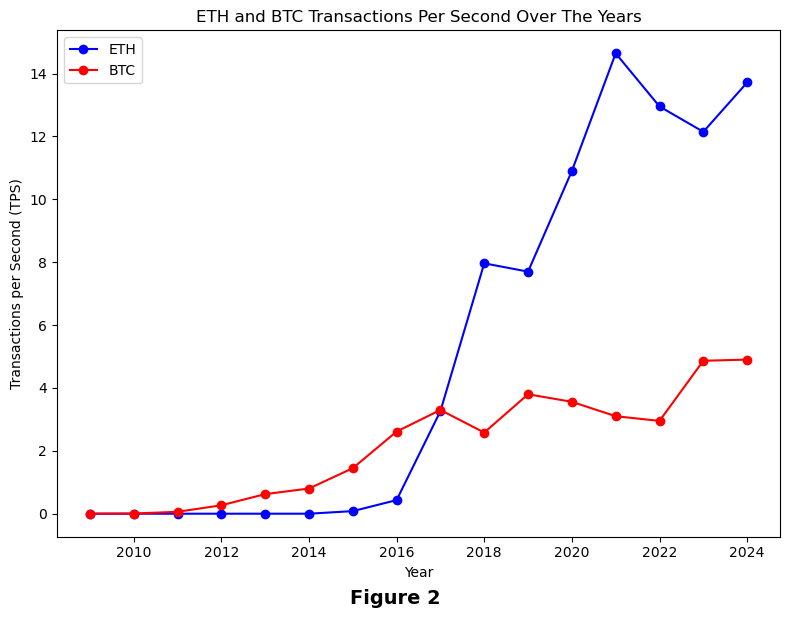

In [111]:
plot_multiple_line_graphs2(
    x_list=[[tps_trans["year"]]*2],
    y_list=[[[tps_trans["eth_transactions_per_sec"], "ETH", "b"], [tps_trans["btc_transactions_per_sec"], "BTC", "r"]]],
    x_labels=["Year"],
    y_labels=["Transactions per Second (TPS)"],
    titles=["ETH and BTC Transactions Per Second Over The Years"],
    formatter=[None],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
    start_figure_number=2
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Read Coingecko API Historical Daily Prices of BTC and ETH

In [18]:
eth_prices = spark.read.csv("crypto_prices/eth-usd-max.csv", header=True)
btc_prices = spark.read.csv("crypto_prices/btc-usd-max.csv", header=True)
eth_prices.createOrReplaceTempView("eth_prices")
btc_prices.createOrReplaceTempView("btc_prices")

## BTC and ETCH Transaction Volume in USD using Coingecko Historical Prices

In [19]:
volume = spark.sql(read_sql_file("sql/volume.sql")).toPandas().fillna(0)
volume

,year,eth_vol_usd,btc_vol_usd
0,2013,0.000000e+00,7.713772e+10
1,2014,0.000000e+00,1.340974e+11
2,2015,1.023266e+08,1.619858e+11
3,2016,6.897527e+09,5.564227e+11
4,2017,1.098248e+12,3.747492e+12
5,2018,7.668154e+11,3.389282e+12
6,2019,1.419953e+11,3.409980e+12
7,2020,3.133019e+11,6.449999e+12
8,2021,2.555531e+12,4.815111e+13
9,2022,1.353725e+12,3.898312e+13


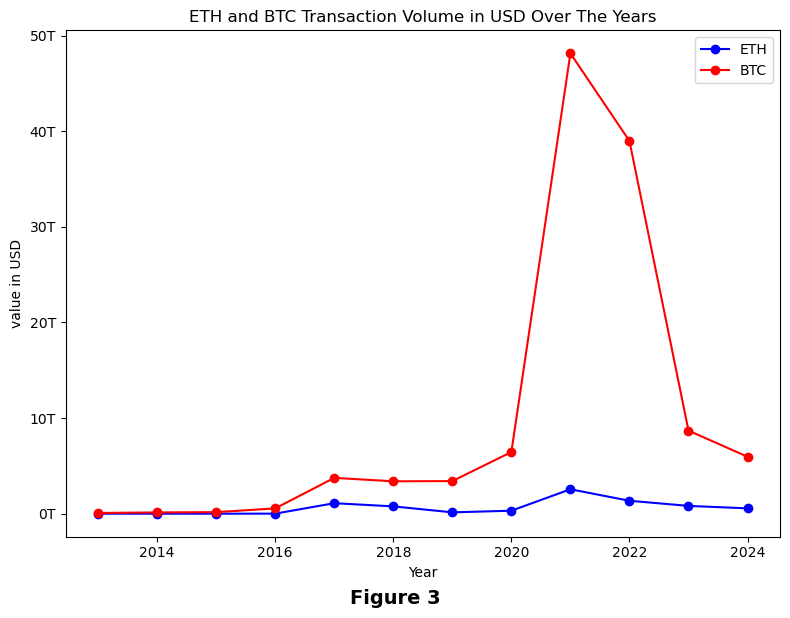

In [122]:
plot_multiple_line_graphs2(
    x_list=[[volume["year"]]*2],
    y_list=[[[volume["eth_vol_usd"], "ETH", "b"], [volume["btc_vol_usd"], "BTC", "r"]]],
    x_labels=["Year"],
    y_labels=["value in USD"],
    titles=["ETH and BTC Transaction Volume in USD Over The Years"],
    formatter=[trillions_formatter],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
    start_figure_number=3
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Total Supply of Bitcoin and Ethereum Over The Years

In [61]:
btc_supply = spark.sql(read_sql_file("sql/btc_supply.sql")).toPandas()
btc_supply

,date,reward
0,2009-01-03,0.00
1,2009-01-09,700.00
2,2009-01-10,3750.00
3,2009-01-11,8400.00
4,2009-01-12,13100.00
...,...,...
5579,2024-04-18,19686493.75
5580,2024-04-19,19687437.50
5581,2024-04-20,19688250.00
5582,2024-04-21,19689125.00


In [62]:
eth_supply = spark.sql(read_sql_file("sql/eth_supply.sql")).toPandas()
eth_supply

,date,max_supply
0,2015-07-30,72034555
1,2015-07-31,72068870
2,2015-08-01,72095335
3,2015-08-02,72122125
4,2015-08-03,72148525
...,...,...
3190,2024-04-23,119094781
3191,2024-04-24,119094781
3192,2024-04-25,119094781
3193,2024-04-26,119094781


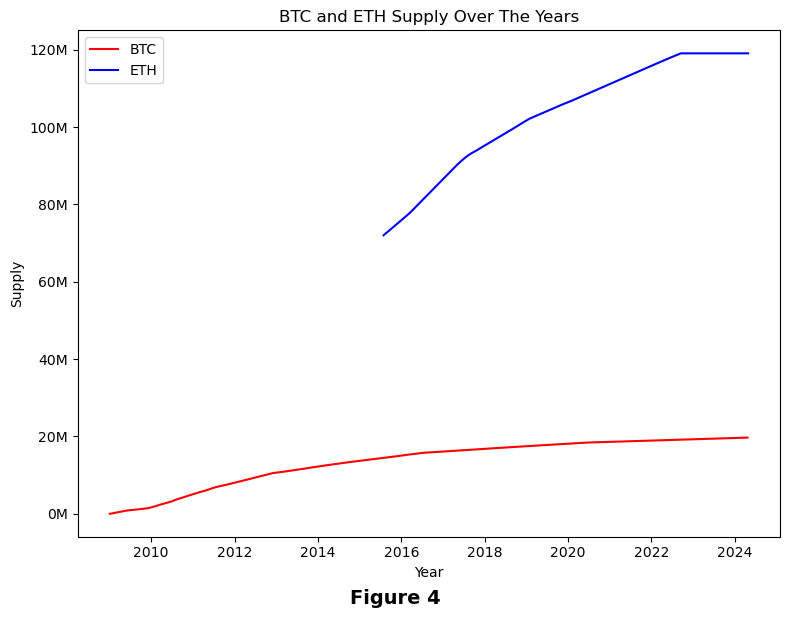

In [121]:
plot_multiple_line_graphs2(
    x_list=[[btc_supply["date"], eth_supply["date"]]],
    y_list=[
        [
            (btc_supply["reward"], "BTC", "r",),
            (eth_supply["max_supply"], "ETH", "b",),
        ]
    ],
    x_labels=["Year"],
    y_labels=["Supply"],
    titles=["BTC and ETH Supply Over The Years"],
    formatter=[millions_formatter],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
    start_figure_number=4,
    marker=None
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Network Value to Transactions (NVT) Ratio

In [67]:
daily_btc_amt = spark.sql("""
SELECT 
    TO_DATE(date) AS date, 
    SUM(input_value) AS total_value
FROM df_btc_trans
GROUP BY date
ORDER BY date
""").toPandas()
daily_btc_amt

,date,total_value
0,2009-01-03,NaN
1,2009-01-09,NaN
2,2009-01-10,NaN
3,2009-01-11,NaN
4,2009-01-12,NaN
...,...,...
5576,2024-04-21,478179.652565
5577,2024-04-22,694279.651478
5578,2024-04-23,734044.347663
5579,2024-04-24,785682.638285


In [86]:
daily_eth_amt = spark.sql("""
SELECT 
    TO_DATE(date) AS date, 
    SUM(value/1E18) AS total_value
FROM df_eth_trans
GROUP BY date
ORDER BY date
""").toPandas()
daily_eth_amt

,date,total_value
0,2015-08-07,2.008723e+06
1,2015-08-08,1.358322e+07
2,2015-08-09,1.165455e+06
3,2015-08-10,1.670911e+06
4,2015-08-11,1.485732e+06
...,...,...
3195,2024-05-06,9.837029e+05
3196,2024-05-07,1.148945e+06
3197,2024-05-08,9.972988e+05
3198,2024-05-09,9.711040e+05


In [87]:
spark.createDataFrame(daily_eth_amt).createOrReplaceTempView("daily_eth_amt")
spark.createDataFrame(daily_btc_amt).createOrReplaceTempView("daily_btc_amt")
spark.createDataFrame(eth_supply).createOrReplaceTempView("eth_supply")
spark.createDataFrame(btc_supply).createOrReplaceTempView("btc_supply")

In [88]:
nvt = spark.sql("""
SELECT
    a.date,
    d.reward/a.total_value as btc_nvt,
    c.max_supply/b.total_value as eth_nvt
FROM daily_btc_amt a
FULL OUTER JOIN daily_eth_amt b
    ON a.date = b.date
FULL OUTER JOIN eth_supply c
    ON a.date = c.date
FULL OUTER JOIN btc_supply d
    ON a.date = d.date
""").toPandas()

In [89]:
# Ensure the 'date' column is in datetime format
nvt['date'] = pd.to_datetime(nvt['date'])

# Filter the DataFrame for dates greater than 2013
_nvt = nvt[nvt['date'] > '2013-12-31']

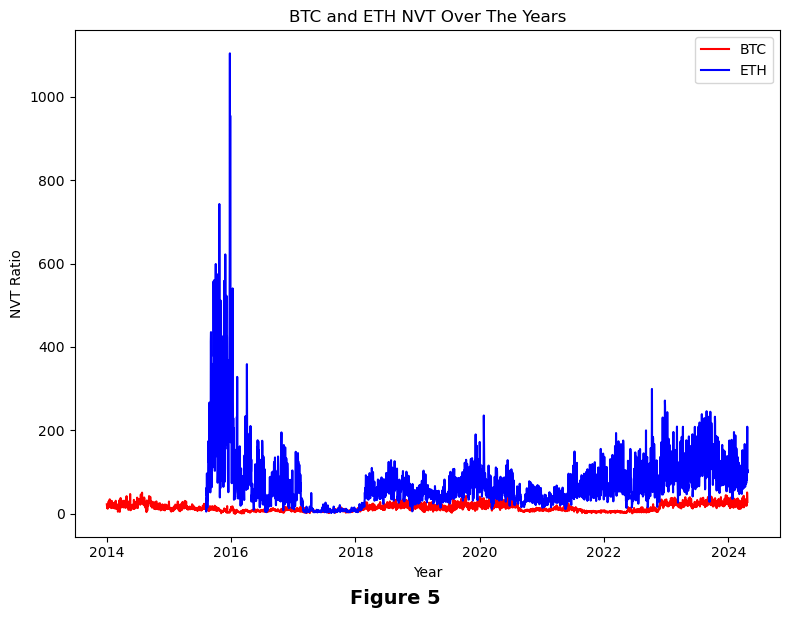

In [120]:
plot_multiple_line_graphs2(
    x_list=[[_nvt["date"], _nvt["date"]]],
    y_list=[
        [
            (_nvt["btc_nvt"], "BTC", "r",),
            (_nvt["eth_nvt"], "ETH", "b",),
        ]
    ],
    x_labels=["Year"],
    y_labels=["NVT Ratio"],
    titles=["BTC and ETH NVT Over The Years"],
    formatter=[None],
    use_legend=[True],
    show_grid=False,
    max_cols=1,
    start_figure_number=5,
    marker=None
)

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [118]:
def plot_multiple_line_graphs2(
    x_list, y_list, x_labels=None, y_labels=None, titles=None,
    formatter=None, use_legend=None, show_grid=False, max_cols=3,
    start_figure_number=1, marker="o",  # New parameter for starting figure number
):
    """
    Plots multiple line graphs in subplots and formats the y-axis in thousands.
    Dynamically sets the layout to a maximum of 3 columns.

    Parameters:
    x_list (list of pd.Series or array-like): List of data for the X-axes
    y_list (list of pd.Series or array-like): List of data for the Y-axes
    x_labels (list of str): List of labels for the X-axes
    y_labels (list of str): List of labels for the Y-axes
    titles (list of str): List of titles for each subplot
    formatter (list of callable): List of formatting functions for the y-axes
    use_legend (list of bool): Whether to show legend for each plot
    show_grid (bool): Whether to show grid on each plot
    start_figure_number (int): Starting number for figure annotations
    """
    n_plots = len(x_list)
    n_cols = min(n_plots, max_cols)
    n_rows = math.ceil(n_plots / max_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))

    # Ensure axes is iterable, even for single plots
    if n_rows == 1 and n_cols == 1:
        axes = [[axes]]
    elif n_rows == 1:
        axes = [axes]
    elif n_cols == 1:
        axes = [[ax] for ax in axes]

    # Flatten axes for easy indexing
    axes = [ax for sublist in axes for ax in sublist]

    for i, (use_legend_, formatter_, x, y) in enumerate(zip(use_legend, formatter, x_list, y_list)):
        ax = axes[i]

        if y == []:
            ax.axis('off')
            continue
        
        # Check if x and y are lists or array-like
        if isinstance(x, (list, pd.Series)) and isinstance(y, (list, pd.Series)):
            for x_, y_ in zip(x, y):
                ax.plot(x_, y_[0], marker=marker, linestyle='-', color=y_[2], label=y_[1])
                if use_legend_:
                    ax.legend()
        else:
            ax.plot(x, y[0], marker=marker, linestyle='-', color=y[2], label=y[1])
            if use_legend_:
                ax.legend()

        # Labels and title
        ax.set_xlabel(x_labels[i] if x_labels else 'X-axis')
        ax.set_ylabel(y_labels[i] if y_labels else 'Y-axis')
        ax.set_title(titles[i] if titles else f'Graph {i + 1}')

        # Format the y-axis to show values in thousands
        if formatter_:
            ax.yaxis.set_major_formatter(FuncFormatter(formatter_))

        # Show grid
        ax.grid(show_grid)

    # Annotate figure number at the top of the figure
    fig.text(0.5, -0.015, f'Figure {start_figure_number}', ha='center', fontsize=14, weight='bold')

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

## References

<sup>1</sup> https://github.com/aws-solutions-library-samples/guidance-for-digital-assets-on-aws/blob/main/analytics/consumer/schema/eth.md \
<sup>2</sup> https://github.com/aws-solutions-library-samples/guidance-for-digital-assets-on-aws/blob/main/analytics/consumer/schema/btc.md 